# Advanced Statistics for Physics Analysis
## R Lab 06

### Student: Toso Simone (2095484)

In [43]:
library(tidyverse)
library(rjags)
library(runjags)
library(tidybayes)
library(gganimate)

In [2]:
theme <- theme(legend.text = element_text(size = 12), axis.title = element_text(size = 15), axis.text = element_text(size = 15), plot.title = element_text(face = "bold", size = 16))

## Ex. 1 - Metropolis - Hastings algorithm

### Given the un-normalized posterior distribution
$g(\theta| x) \propto \frac{1}{2}\exp{-\frac{(\theta+3)^2}{2}} + \frac{1}{2}\exp{-\frac{(\theta-3)^2}{2}}$
### draw a Markov Chain from it using a Metropolis-Hastings algorithm. Use a Norm(0,1) as random-walk candidate density. 

In [3]:
#Takes as input:
# func: function to sample from (returns real value, no log)
# theta0: initial parameter
# nSamples: how many samples?
# sigma: std of the normal distribution
# burnin: number of initial samples to discard
# hastings: boolean, answers to "Is the proposal function independent from the last parameter?"
# thinning: thinning parameter

metropolis_hastings <- function(func, theta_0, nSamples, sigma, burn_in = 5000, hastings = TRUE, thinning = 1){
    theta <- theta_0 # Initial value
    thetas <- c(theta) # Samples
    
    for(i in 1:nSamples){
        theta_proposed <- ifelse(hastings, rnorm(1,mean = 0, sd = sigma), rnorm(1, mean = theta, sd = sigma)) #proposal
        f_proposed <- func(theta_proposed)
        f_theta <- func(theta)

        #Evaluate rho
        rho <- 0.
        if (hastings){
        rho <- f_proposed / f_theta * dnorm(theta, 0, sigma^2) / dnorm(theta_proposed, 0, sigma^2)
        }
        else{
            rho <- f_proposed / f_theta #If the proposal distribution is Norm(theta, sigma^2) the terms cancel out 
        }
        rho <- min(rho, 1)
        #print(paste("rho", rho))
        #Check condition on rho
        u <- runif(1, 0, 1)
        #print(paste("u", u))
        if (u < rho){
            theta <- theta_proposed
        }
        
        thetas <- c(thetas, theta)
    }
    
    return(thetas[seq(from = burn_in, to = length(thetas) - burn_in, by = thinning)])
}

In [4]:
f <- function(x){
    return( 1/2 * (exp(-(x + 3)^2/2) + exp(-(x - 3)^2 / 2) ))
}

#### Let's try with the Hastings algorithm.

In [5]:
samples <- metropolis_hastings(func = f, theta_0 = rnorm(1,0,1), nSamples = 100000, sigma = 1, hastings = TRUE)

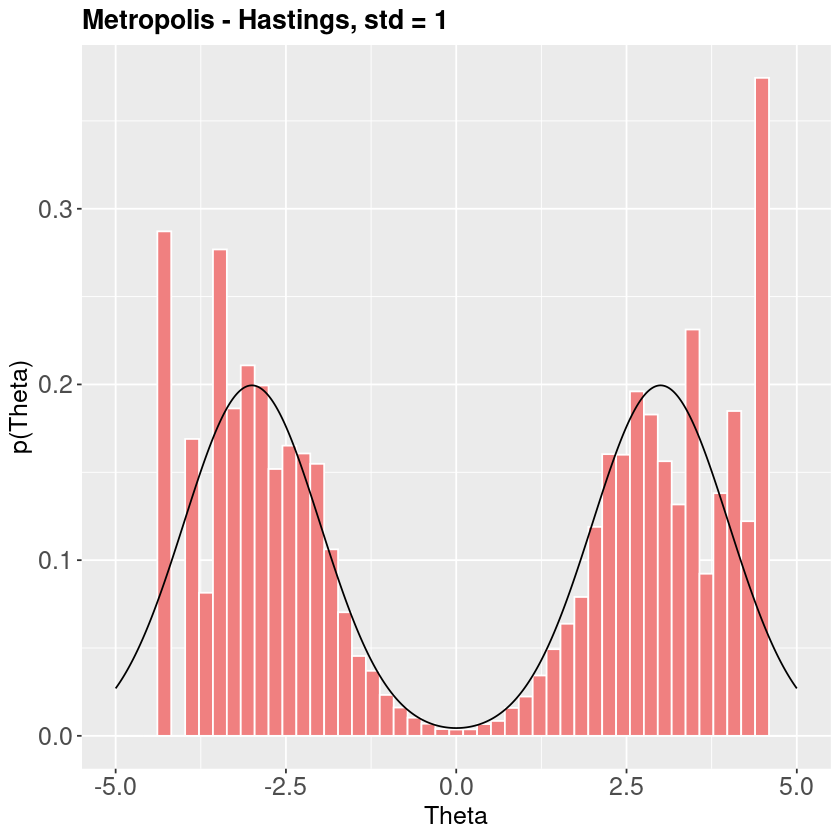

In [6]:
p <- ggplot() + geom_histogram(aes(x = samples, y = after_stat(density)),
                               color = "white", fill = "lightcoral", bins = 50)

xs <- seq(from = -5, to = 5, by = 0.001)
ys <- f(xs)
Z <- integrate(f, lower = -Inf, upper = Inf)$value #Normalize posterior
p <- p + geom_line(aes(x = xs, y = ys/Z), color = "black")
p + ggtitle("Metropolis - Hastings, std = 1") + theme + labs(x = "Theta", y = "p(Theta)")

#### Let's try with $Q(s|\theta) = N(\theta,1)$

In [7]:
samples <- metropolis_hastings(func = f, theta_0 = rnorm(1,0,1), nSamples = 100000, sigma = 1, hastings = FALSE)

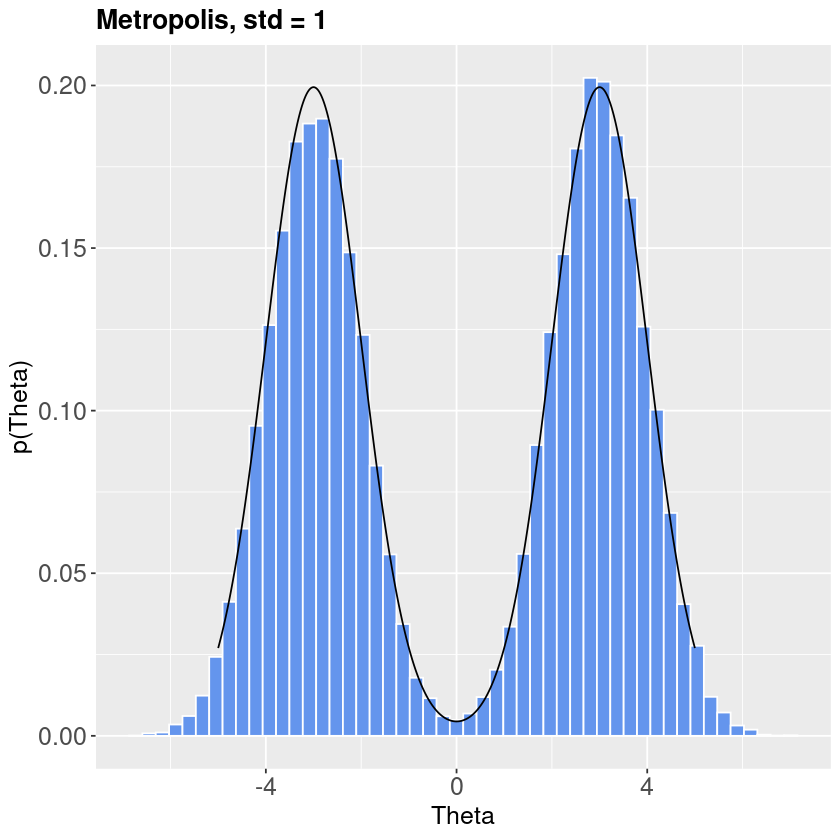

In [8]:
p <- ggplot() + geom_histogram(aes(x = samples, y = after_stat(density)),
                               color = "white", fill = "cornflowerblue", bins = 50)

xs <- seq(from = -5, to = 5, by = 0.001)
ys <- f(xs)
Z <- integrate(f, lower = -Inf, upper = Inf)$value
p <- p + geom_line(aes(x = xs, y = ys/Z), color = "black")
p + ggtitle("Metropolis, std = 1") + theme + labs(x = "Theta", y = "p(Theta)")

### Analyze the chain with the CODA package and plot the chain autocorrelation. 
#### We do it with the $Q(s|\theta) = N(\theta, \sigma = 1)$ proposal distribution, since we seem to get better results.

In [9]:
samples_mcmc <- as.mcmc(samples)

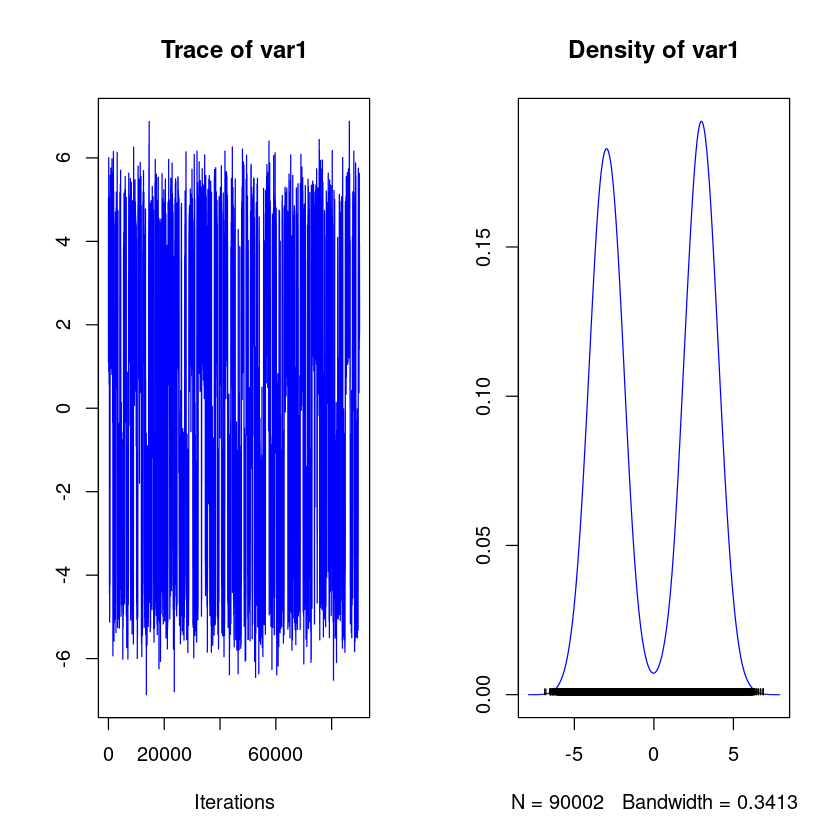

In [10]:
plot(samples_mcmc, col = "blue")

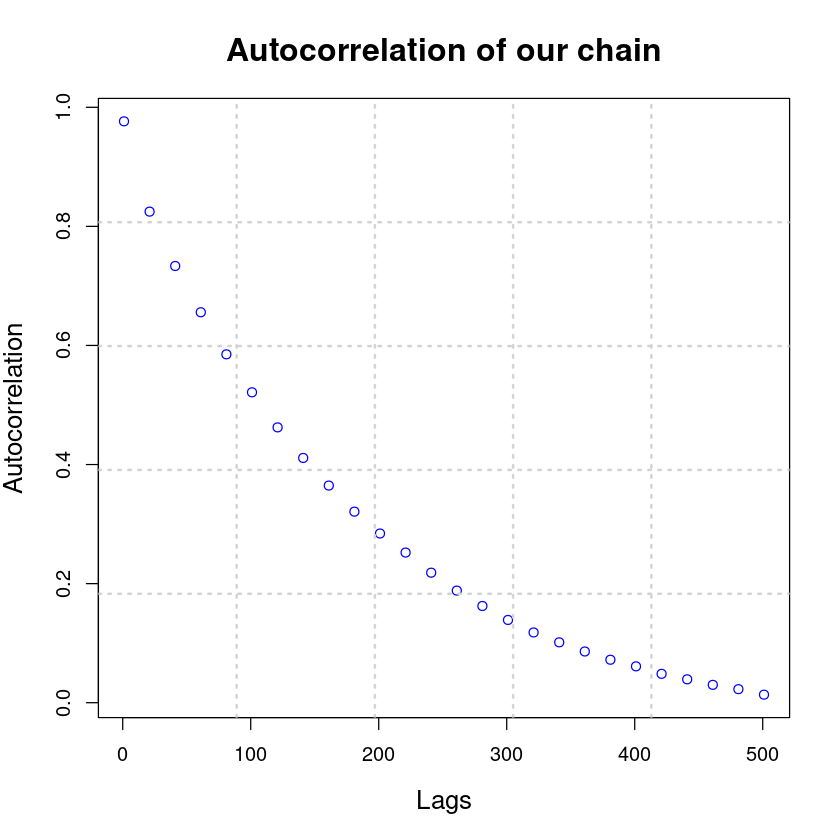

In [11]:
#Evaluate autocorrelation
lags <- seq(from = 1, to = 501, by = 20)
autocorrelations <- autocorr(samples_mcmc, lags = lags)

#Make plot
plot(lags, autocorrelations, xlab = "Lags", ylab = "Autocorrelation", main = "Autocorrelation of our chain", 
     cex.main = 1.6, cex.lab = 1.3, col = "blue")
grid(5,5, lwd = 2) #Add grid to graph

#### The autocorrelation decreases as a function of the lag. This is understandable, considering that our proposal distribution is centered on the last accepted value.

### Try to use different burn-in cycles and thinning and plot the corresponding posterior distribution and the chain autocorrelation function. What are the best parameters ?

In [12]:
#Generate data. Then we will apply different burnins and thinnings
samples_total <- metropolis_hastings(func = f, theta_0 = rnorm(1,0,1), 
                                       nSamples = 200000, sigma = 1, burn_in = 1,
                                       hastings = FALSE, thinning = 1)

In [13]:
1 %/% 4

[1] 0

In [14]:
(1:16) %% 4

[1] 1 2 3 0 1 2 3 0 1 2 3 0 1 2 3 0

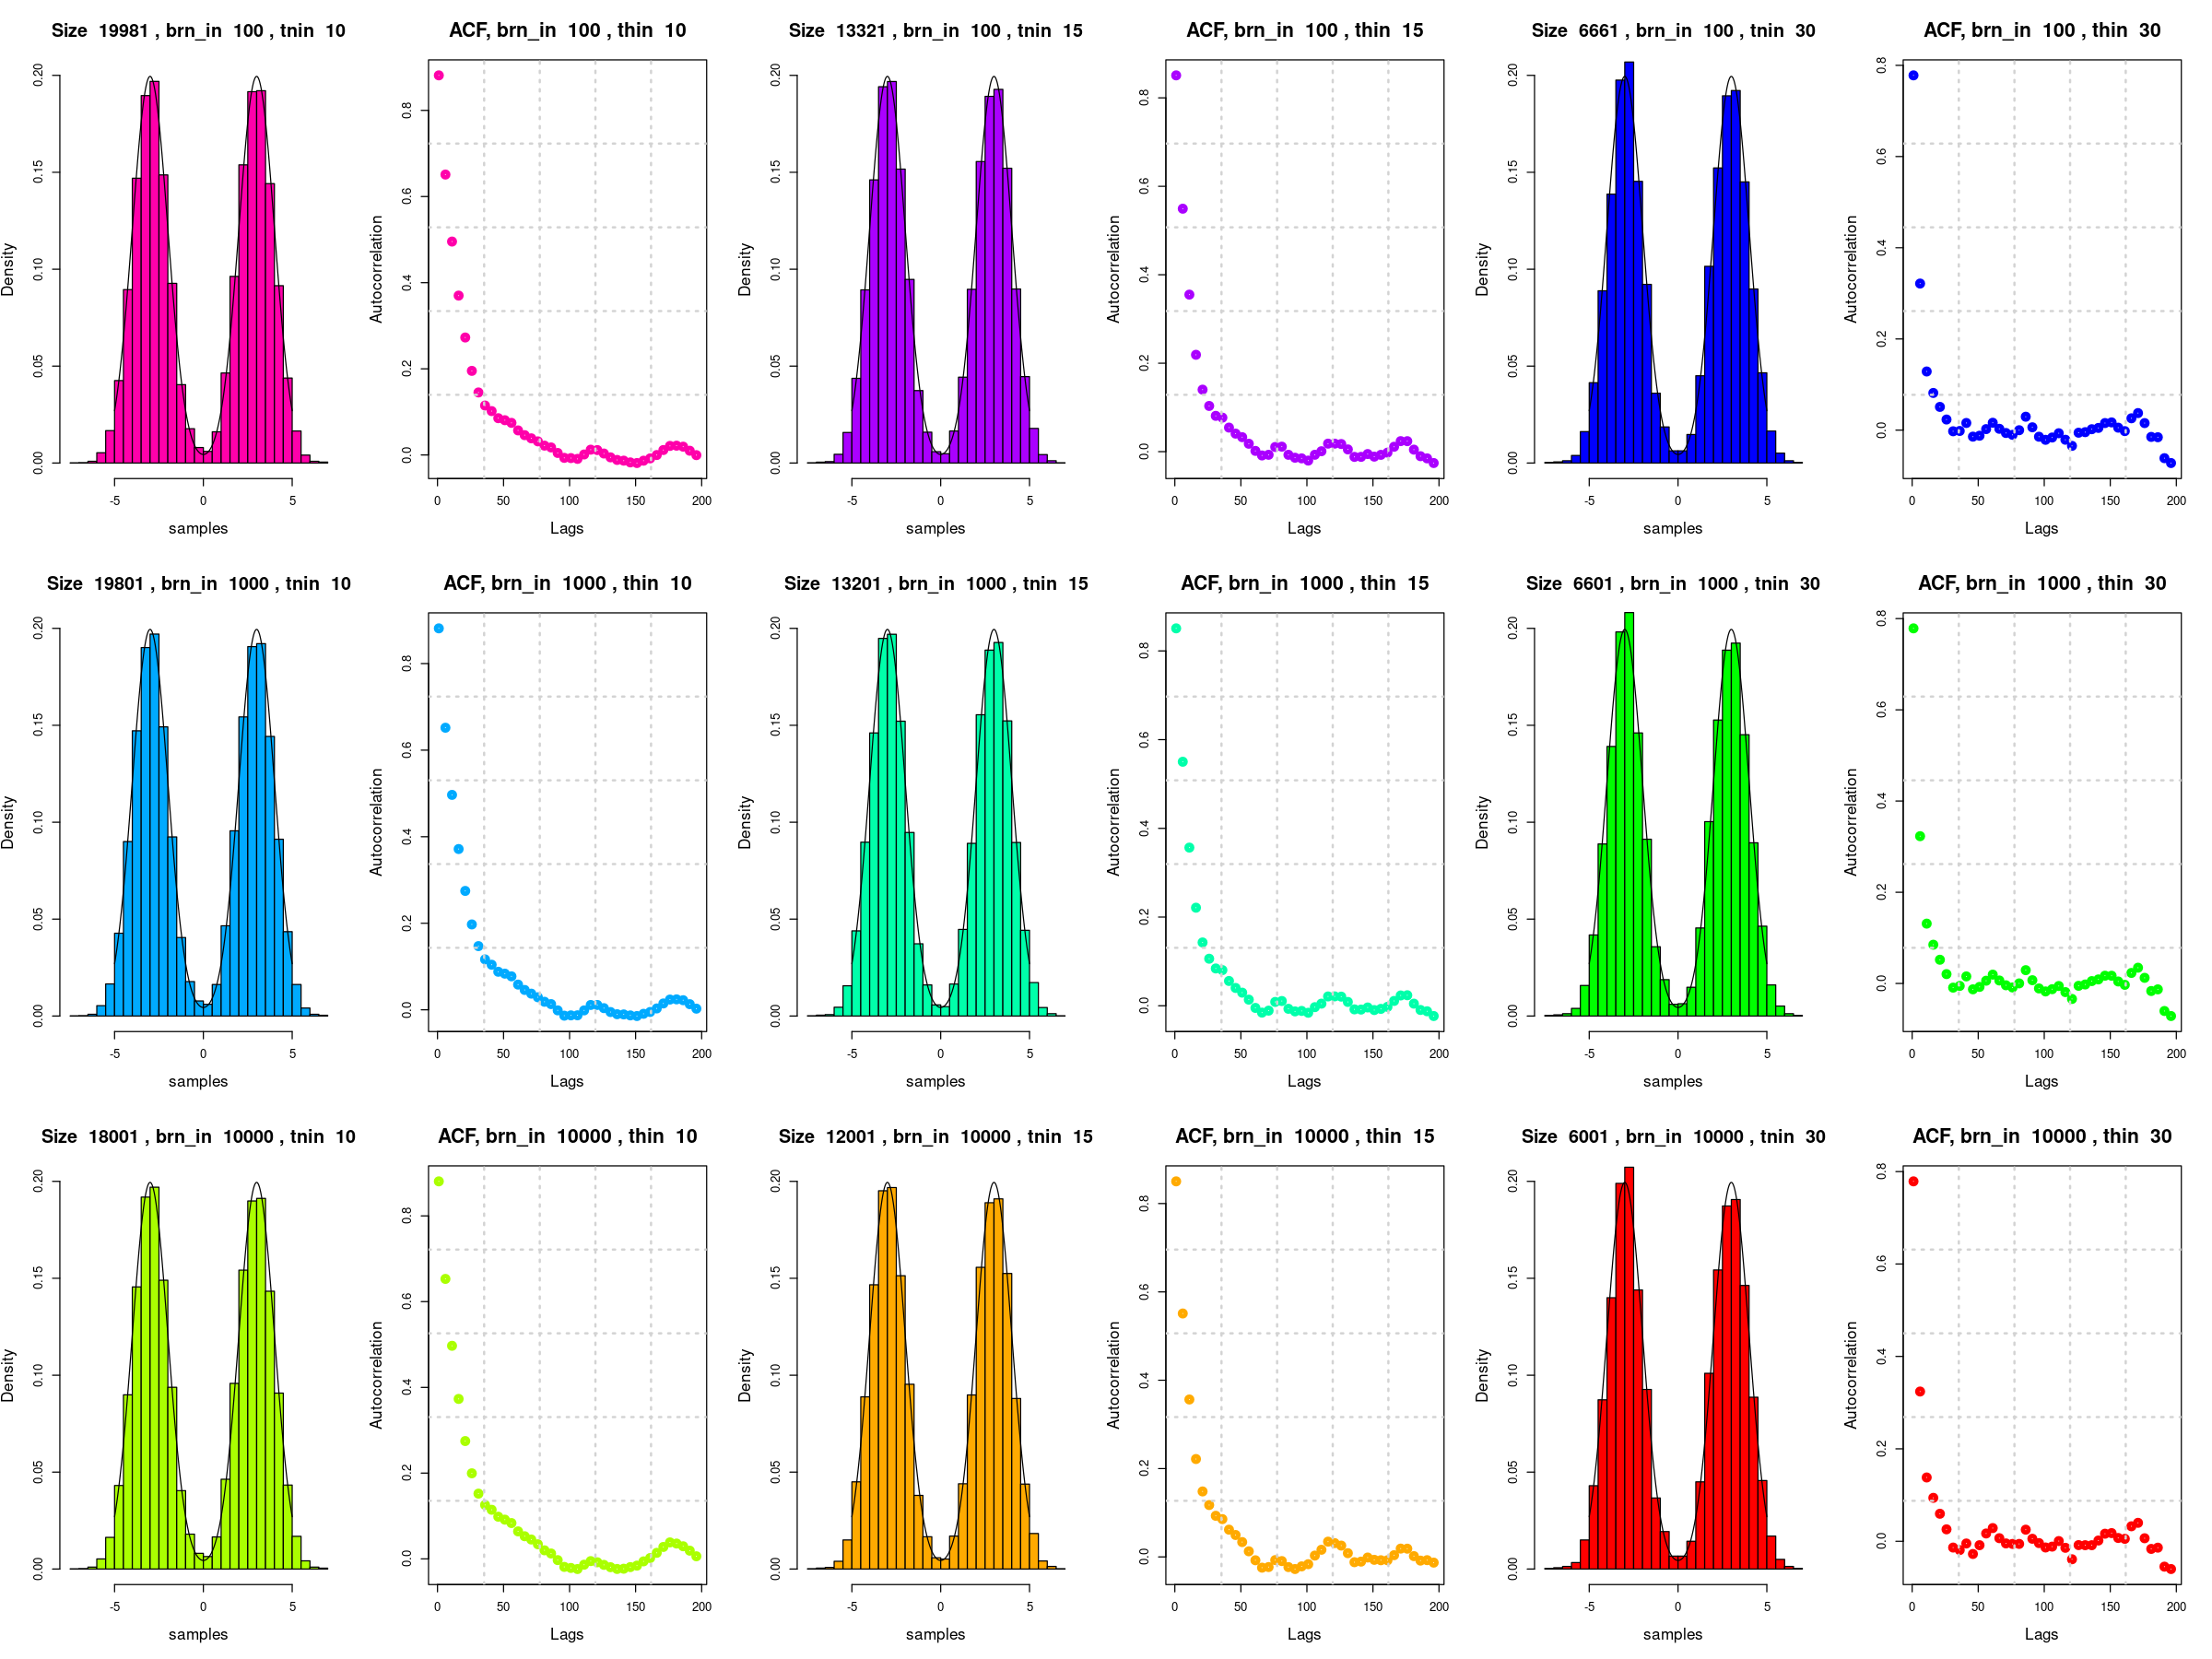

In [15]:
#We try these couples (burnins, thinnings).
burnins <- c(100, 1000, 10000)
thinnings <- c(10, 15, 30)

#Prepare layout for plotting
options(repr.plot.width=20, repr.plot.height=15)
par(mfrow= c(3, 6))
colors <- rainbow(9)

#Lags for autocorrelation
lags <- seq(from = 1, to = 100, by = 20)

#First try all thinnings with the first burnin
counter <- 1 #
for(burnin in burnins){
        for(thinning in thinnings){
    
        samples <- samples_total[seq(from = burnin, to = length(samples_total) - burnin, by = thinning)]

        #Plot density        
        xs <- seq(from = -5, to = 5, by = 0.001)
        ys <- f(xs)
        Z <- integrate(f, lower = -Inf, upper = Inf)$value

        hist(samples, freq = FALSE, col = colors[10 - counter], cex.lab = 1.3, cex.main = 1.5, ylim = c(0, 0.2),
            main = paste("Size ", length(samples), ", brn_in ", burnin, ", tnin ", thinning),
             breaks = 20)
        lines(xs, ys/Z)


        #Evaluate ACF
        samples_mcmc <- as.mcmc(samples)
        lags <- seq(from = 1, to = 200, by = 5)
        autocorrelations <- autocorr(samples_mcmc, lags = lags)

        #Plot ACF
        plot(lags, autocorrelations, xlab = "Lags", ylab = "Autocorrelation", 
             main = paste("ACF, brn_in ", burnin, ", thin ", thinning),
             cex.main = 1.6, cex.lab = 1.3, col = colors[10 - counter], lwd = 4)
        grid(5,5, lwd = 2) #Add grid to graph

        #Increase counter to pass to next graph
        counter <- counter + 1 
    }
}

#### The thinning impacts greatly the ACF, while the burnin does not seem to have as much of an impact.  Out of the tried combinations, the combination "Burn - in = 100, thinning  = 15" gives a high sample size (13321 samples) and low ACF.

### Exercise 2 - Covid Vaccine analysis


### Create a Markov Chain Monte Carlo JAGS or stan to test the efficacy of each Vaccine. Infere the 95% credibility interval.

In [16]:
#Dataset: cases, total, cases_placebo, total_placebo
jcovden <- c(116, 19630, 348, 19691)
moderna <- c(11, 14134, 185, 14073)
astrazeneca <- c(64, 5258, 154, 5210)

dataset <- (data.frame(jcovden, moderna, astrazeneca))
names <- c("jcovden", "moderna", "astrazeneca")
rownames(dataset) <- c("Cases_vaccine", "Total_vaccine", "Cases_placebo", "Total_placebo")

In [17]:
dataset

jcovden moderna astrazeneca
Cases_vaccine   116      11     64       
Total_vaccine 19630   14134   5258       
Cases_placebo   348     185    154       
Total_placebo 19691   14073   5210

In [18]:
#Function to plot histogram and find confidence interval.
#On the histogram we highlight the Confidence Interval (CI) and write the mean
#Apart from plotting, returns mean and confidence interval

plotHistogram <- function(data, color, title){
    breaks <- hist(data, plot = FALSE)$breaks
    densities <- hist(data, plot = FALSE)$density

    cumulatives <- c()
    for(i in 1:length(densities)-1){
        entry <- 0
            for(j in 1:i){
                entry <- entry + densities[j]*(breaks[j+1]-breaks[j])
            }
        cumulatives <- c(cumulatives,entry)
    }
        
    #Find indices of CI borders
    indeces_min <- c(min(which(cumulatives >= 0.025))-1, min(which(cumulatives >= 0.025)))
    indeces_max <- c(max(which(cumulatives <= 0.975)), max(which(cumulatives <= 0.975))+1)

    #Choose the index that is closer
    if(abs(cumulatives[indeces_min[1]] - 0.025) < abs(cumulatives[indeces_min[2]]-0.025)){
        indeces_min <- indeces_min[1]
    }
    else{
        indeces_min <- indeces_min[2]
    }
    
    if(abs(cumulatives[indeces_max[1]] - 0.975) < abs(cumulatives[indeces_max[2]]-0.975)){
        indeces_max <- indeces_max[1]
    }
    else{
        indeces_max <- indeces_max[2]
    }
    
    #Shade borders
    
    colors <- rep("gray86", length(densities))
    colors[1:length(densities) >= indeces_min & 1:length(densities) <= indeces_max] <- color
    
    hist(data, freq = FALSE, col = colors, main = paste(title, ", CI = [", breaks[indeces_min], ",", breaks[indeces_max], "]", " Mean:", format(mean(data), digits = 4)),
         sub = paste("Mean:", format(mean(data), digits = 4)), xlab = "p", cex.lab = 1.2, cex.sub = 1., cex.main = 1.5)
    
    #Return mean and CI
    return( c(mean(data), breaks[indeces_min], breaks[indeces_max]))
}

Warning message:
“No initial values were provided - JAGS will use the same initial values for all chains”
Warning message:
“You attempted to start parallel chains without setting different PRNG for each chain, which is not recommended.  Different .RNG.name values have been added to each set of initial values.”


Calling 4 simulations using the parallel method...
All chains have finished
Simulation complete.  Reading coda files...
Coda files loaded successfully
Finished running the simulation


Warning message in as.mcmc.runjags(chain):
“Combining the 4 mcmc chains together”
Warning message:
“No initial values were provided - JAGS will use the same initial values for all chains”
Warning message:
“You attempted to start parallel chains without setting different PRNG for each chain, which is not recommended.  Different .RNG.name values have been added to each set of initial values.”


Calling 4 simulations using the parallel method...
All chains have finished
Simulation complete.  Reading coda files...
Coda files loaded successfully
Finished running the simulation


Warning message in as.mcmc.runjags(chain):
“Combining the 4 mcmc chains together”
Warning message:
“No initial values were provided - JAGS will use the same initial values for all chains”
Warning message:
“You attempted to start parallel chains without setting different PRNG for each chain, which is not recommended.  Different .RNG.name values have been added to each set of initial values.”


Calling 4 simulations using the parallel method...
All chains have finished
Simulation complete.  Reading coda files...
Coda files loaded successfully
Finished running the simulation


Warning message in as.mcmc.runjags(chain):
“Combining the 4 mcmc chains together”


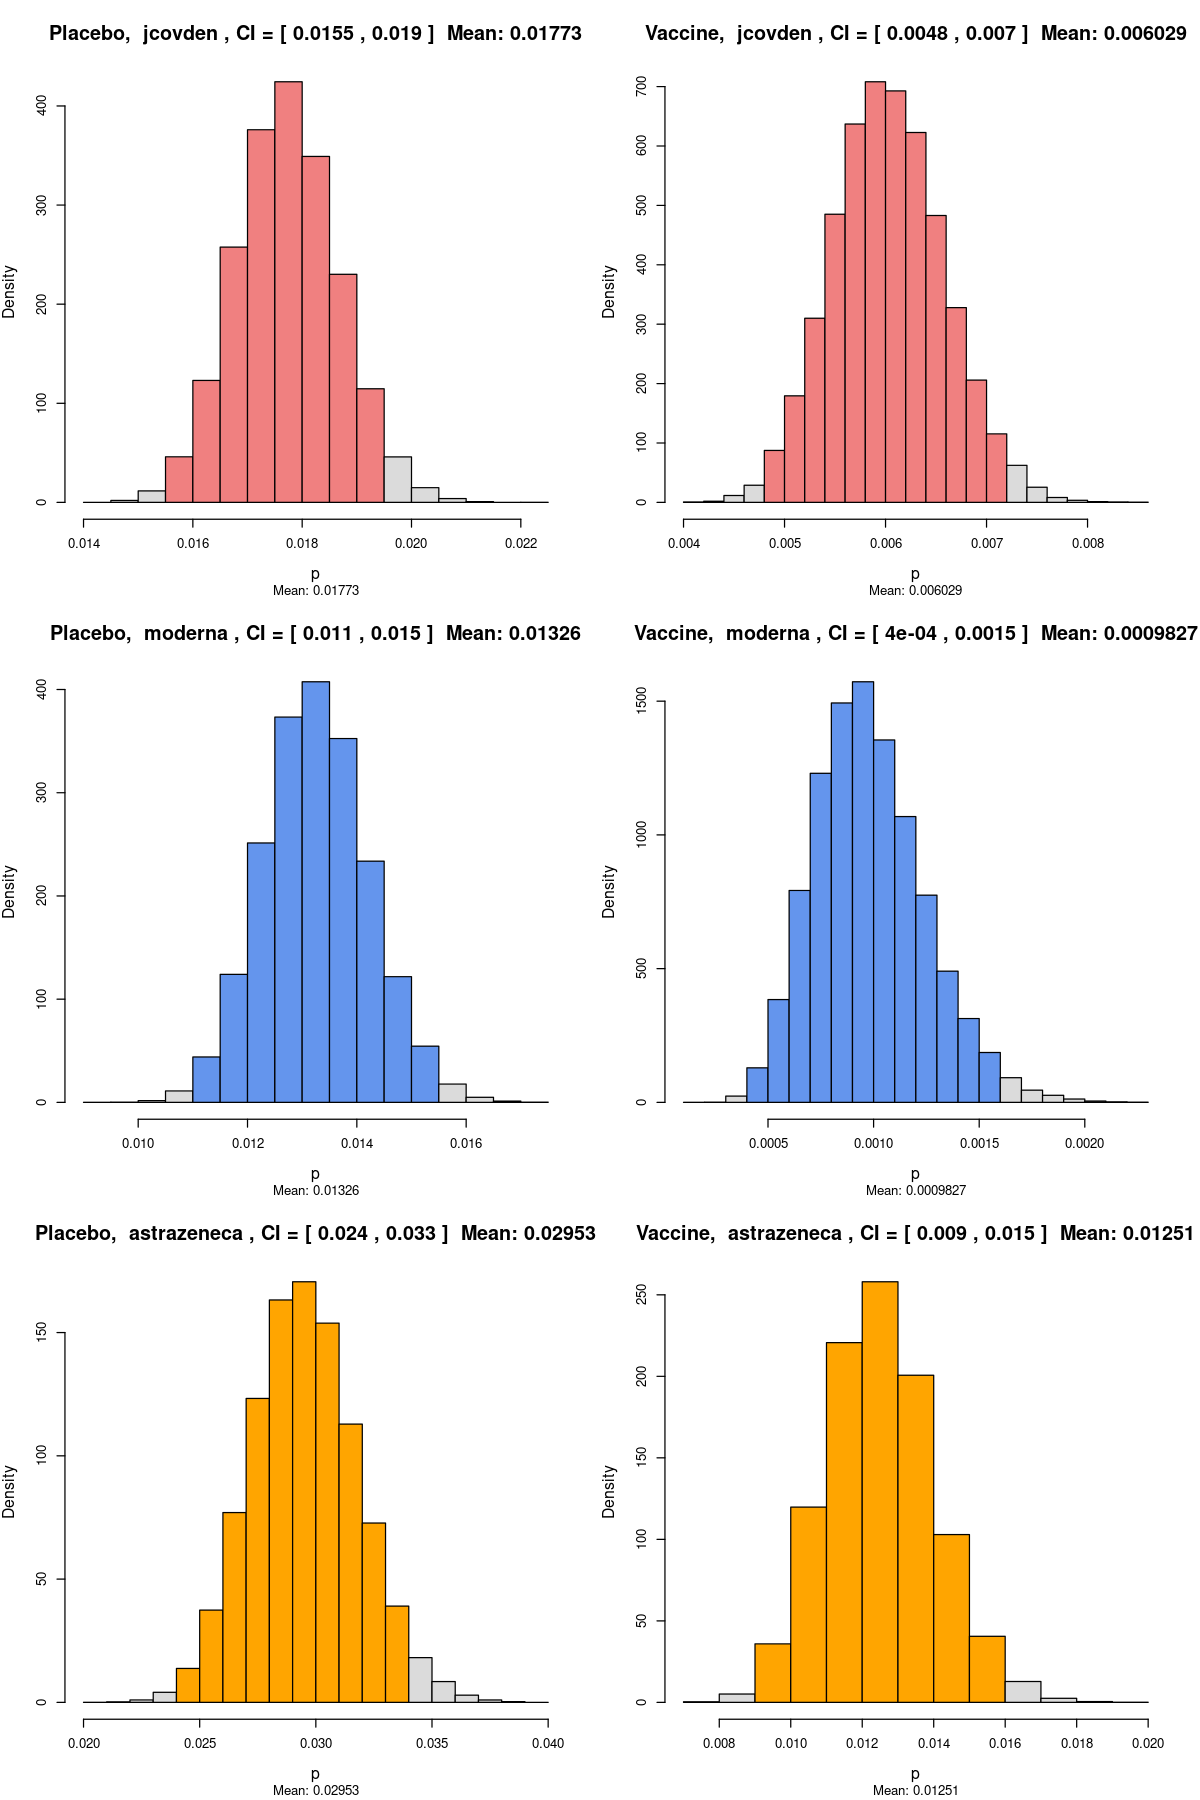

In [19]:
colors <- c("lightcoral", "cornflowerblue", "orange")
par(mfrow= c(3, 2))
options(repr.plot.width=10, repr.plot.height=15)

mcees <- list()

column_names = c("Mean_vacc","CI_lower","CI_upper", "Mean_plac", "CI_lower_plac", "CI_upper_plac") 
df = data.frame(matrix(nrow = 0, ncol = length(column_names))) 
colnames(df) = column_names

for(i in 1:length(names)){
    cases_vaccine <- dataset[1, i]
    total_vaccine <- dataset[2, i]
    cases_placebo <- dataset[3, i]
    total_placebo <- dataset[4, i]

    patients <- c(rep("Vaccine", total_vaccine), rep("Placebo", total_placebo)) #Vaccine or Placebo?
    results <- c(rep("Positive", cases_vaccine), 
                rep("Negative", total_vaccine - cases_vaccine),
                rep("Positive", cases_placebo),
                rep("Negative", total_placebo - cases_placebo)) #Positive or negative?

    #Jags model as string (we use a dbeta(3,100) prior as done in class)
    jagsModel <- "model{
        for( i in 1:nTot){
            results[i] ~ dbern(theta[patients[i]]) 
        }
        for(k in 1:nClass){
            theta[k] ~ dbeta(3,100)
        }
    }"

    #Data as input for run.jags
    dataList <- list(
        results = ifelse(results == "Negative", 0, 1),
        patients = as.integer(factor(patients)),
        nTot = total_placebo + total_vaccine,
        nClass = nlevels(factor(patients)) )

    chain <- run.jags(jagsModel, sample = 10000, 
                     n.chains = 4, method = "parallel",
                     monitor = "theta", data = dataList, silent.jags = TRUE)
    mcee <- as.mcmc(chain)
    param_plac <- plotHistogram(mcee[1:40000,1], colors[i], paste("Placebo, ", names[i]))  
    param_vacc <- plotHistogram(mcee[1:40000,2], colors[i], paste("Vaccine, ", names[i]))
    
    df[nrow(df) + 1,] <- c(param_vacc, param_plac)
    
}



For a given vaccine, let's call $p_{vac}$ the probability of testing positive when you have received the vaccine, and $p_{plac}$ the probability of testing positive if you have received the placebo. In all three cases, the probability $p_{plac}$ is not compatible with $p_{vac}$. Actually, the 95% CI of $p_{plac}$ doesn't even intersect the 95% CI of $p_{vac}$. The means (shown in the graph, together with the confidence intervals) of the posterior distributions for $p_{vac}$ are $\approx 0.006$ (jcovden), $\approx 0.001$ (moderna) and $\approx 0.01$ (astrazeneca).

Let's check how these values compare with the ratio $\frac{\text{n. positive}}{\text{n. vaccine}}$ of vaccinated people who resulted positive.

In [20]:
dataset['Ratio', ] <- dataset['Cases_vaccine', ] / dataset['Total_vaccine',]
dataset['Ratio_placebo', ] <- dataset['Cases_placebo', ] / dataset['Total_placebo', ]

In [21]:
dataset['Ratio', ]

jcovden     moderna      astrazeneca
Ratio 0.005909322 0.0007782652 0.01217193

As shown above, the ratios resemble the mean evaluated through JAGS.

We can evaluate the difference in rate as $\frac{\text{rate placebo}-\text{rate vaccine}}{\text{rate placebo}}$.

In [22]:
rownames(df) <- names
df

Mean_vacc   CI_lower CI_upper Mean_plac  CI_lower_plac
jcovden     0.006029086 0.0048   0.0070   0.01773279 0.0155       
moderna     0.000982668 0.0004   0.0015   0.01326092 0.0110       
astrazeneca 0.012505637 0.0090   0.0150   0.02953195 0.0240       
            CI_upper_plac
jcovden     0.019        
moderna     0.015        
astrazeneca 0.033

In [23]:
df$efficacy <- (df$Mean_plac - df$Mean_vacc) / df$Mean_plac

In [24]:
df

Mean_vacc   CI_lower CI_upper Mean_plac  CI_lower_plac
jcovden     0.006029086 0.0048   0.0070   0.01773279 0.0155       
moderna     0.000982668 0.0004   0.0015   0.01326092 0.0110       
astrazeneca 0.012505637 0.0090   0.0150   0.02953195 0.0240       
            CI_upper_plac efficacy 
jcovden     0.019         0.6600035
moderna     0.015         0.9258975
astrazeneca 0.033         0.5765388

### Exercise 3
According to the official COVID-19 vaccination data, 70% of the world population has received at least one dose of a COVID-19 vaccine. A global vaccination dataset is available [5].

The European Centre for Disease Prevention and Control published a downloadable file [6] containing information on COVID-19 vaccination in the EU/EEA.

First, we download the dataset from https://github.com/owid/covid-19-data/tree/master/public/data/vaccinations

In [25]:
#Load the vaccinations.csv file (source: )
data <- read.csv("vaccinations.csv")

In [26]:
colnames(data)

[1] "location"                            "iso_code"                           
 [3] "date"                                "total_vaccinations"                 
 [5] "people_vaccinated"                   "people_fully_vaccinated"            
 [7] "total_boosters"                      "daily_vaccinations_raw"             
 [9] "daily_vaccinations"                  "total_vaccinations_per_hundred"     
[11] "people_vaccinated_per_hundred"       "people_fully_vaccinated_per_hundred"
[13] "total_boosters_per_hundred"          "daily_vaccinations_per_million"     
[15] "daily_people_vaccinated"             "daily_people_vaccinated_per_hundred"

### Cumulative number of vaccinated people

In [27]:
data <- data[!is.na(data$total_vaccinations) & !is.na(data$people_vaccinated), ]

In [28]:
#Read string date as a date
data$date <- as_date(data$date)

In [29]:
#We use the entries with iso code OWID_WRL, which correspond to the whole world
data <- data[data$iso_code=="OWID_WRL", ]

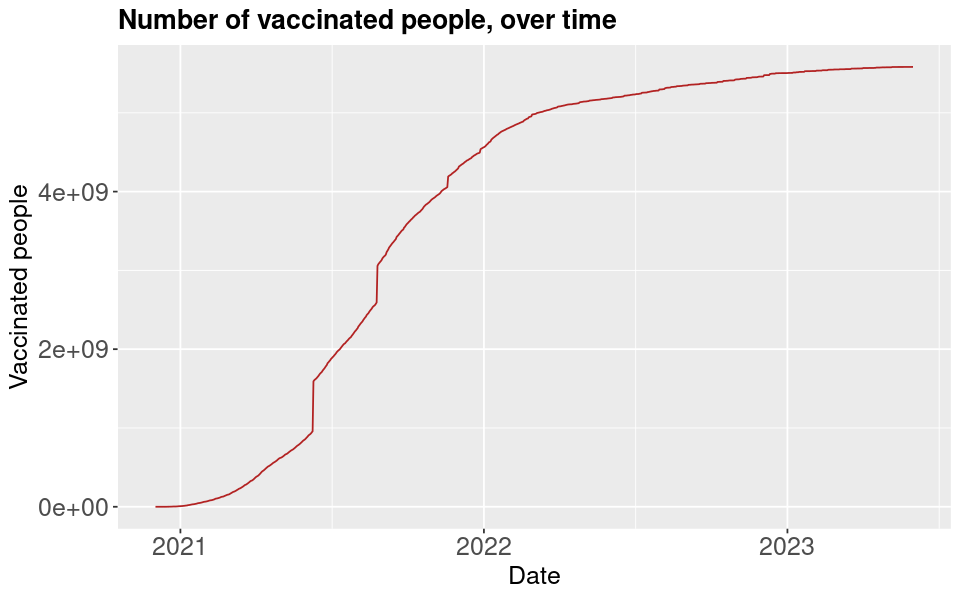

In [30]:
#Cumulative --> find sum of total vaccinations on each day
options(repr.plot.width=8, repr.plot.height=5)
p <- ggplot(data) + geom_line(aes(x = date, y = people_vaccinated), color = "firebrick")
p <- p + ggtitle("Number of vaccinated people, over time")
p <- p + theme + labs(x = "Date", y = "Vaccinated people")
p

### Vaccinations given (daily)

In [31]:
data <- data[!is.na(data$daily_vaccinations), ]

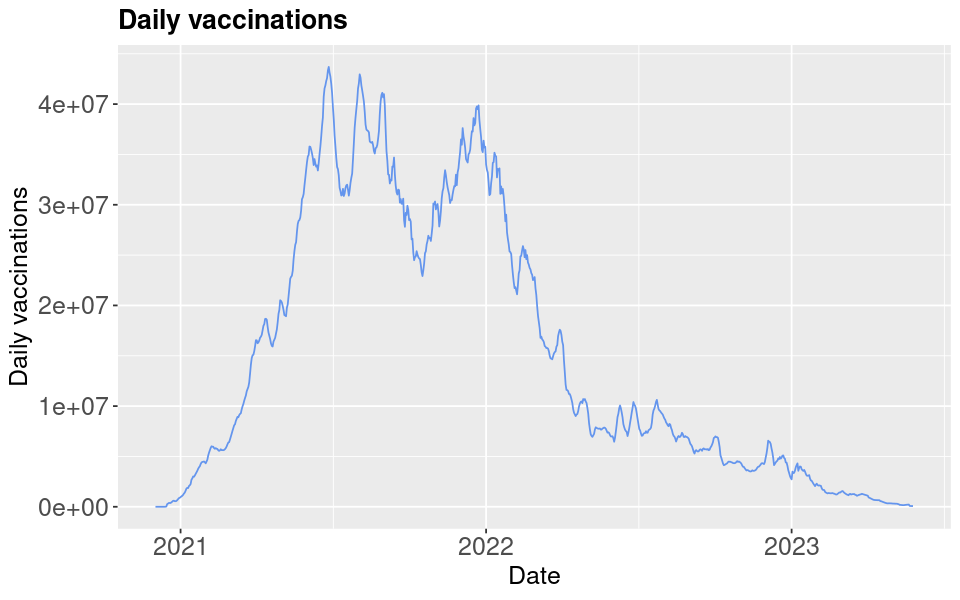

In [32]:
# Daily vaccinations
p <- ggplot(data) + geom_line(aes(x = date, y = daily_vaccinations), color = "cornflowerblue")
p + ggtitle("Daily vaccinations") + labs(x = "Date", y = "Daily vaccinations", color = NULL) + theme

### Vaccinations given (weekly average)

In [33]:
difftime(data$date[4], data$date[1], units = "days") < 5

[1] TRUE

In [34]:
# For every day, make average over previous 7 days
weekly_averages <- c()
days_week <- c()

day <- data$date[1]

while(day %in% data$date){
    average <- mean(data$daily_vaccinations[difftime(data$date, day) < 7 & difftime(data$date, day) >= 0])
    weekly_averages <- c(weekly_averages, average)
    days_week <- c(days_week, format(day, "%Y-%m-%d"))
    day <- day + days(7)    
    
}

In [35]:
days_week <- as.Date(days_week)

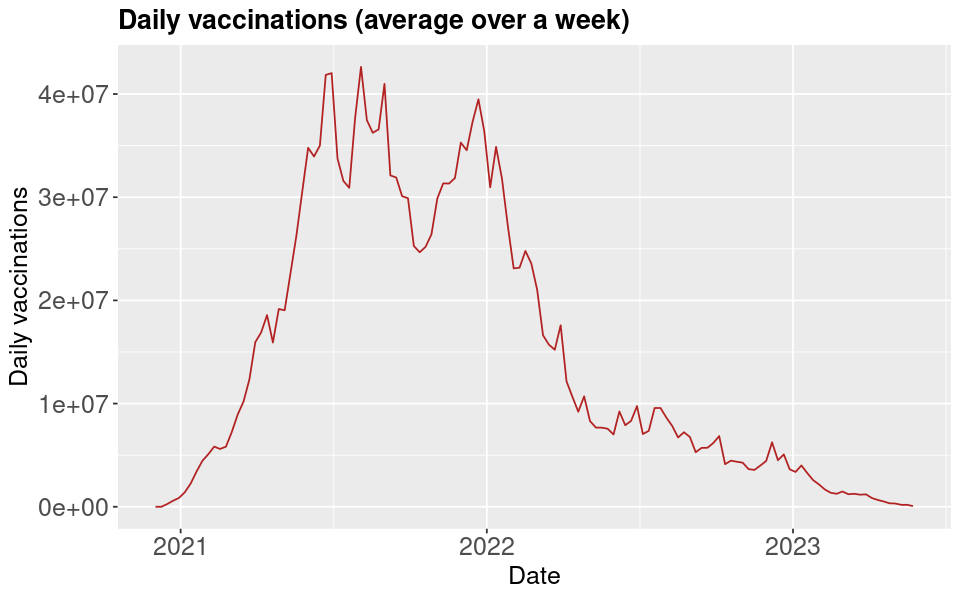

In [36]:
p <- ggplot() + geom_line(aes(x = days_week, y = weekly_averages), color = "firebrick")
p + ggtitle("Daily vaccinations (average over a week)") + labs(x = "Date", y = "Daily vaccinations") + theme

### Confirmed deaths, cumulative

In [37]:
data_deaths <- read.csv("total_deaths.csv")

In [38]:
data_deaths <- data_deaths[!is.na(data_deaths$World), ]

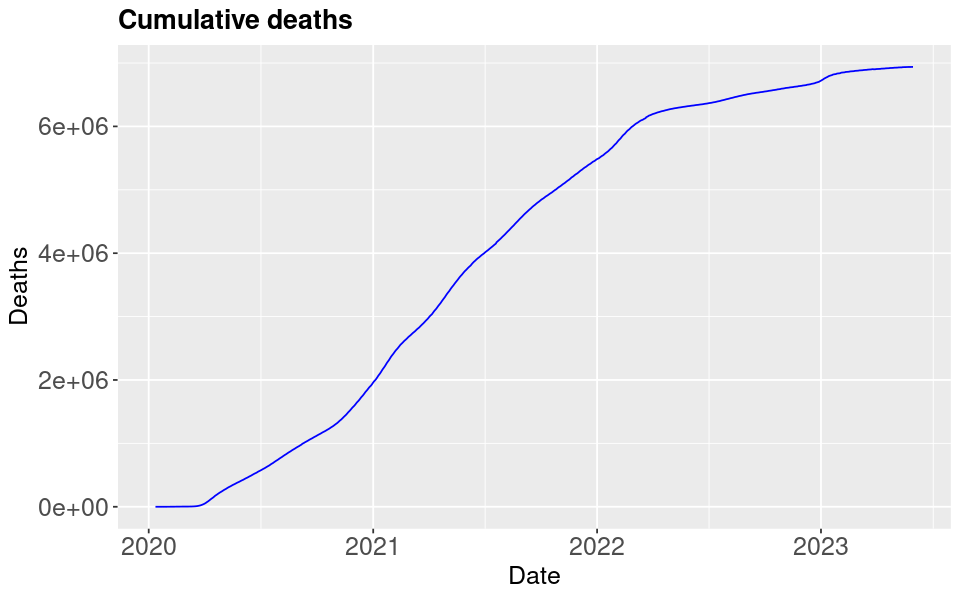

In [39]:
p <- ggplot(data_deaths) + geom_line(aes(x = as.Date(date), y = World), color = "blue")
p + ggtitle("Cumulative deaths") + labs(x = "Date", y = "Deaths") + theme

### Confirmed deaths, weekly average

In [40]:
new_deaths <- read.csv("new_deaths.csv")
new_deaths$date <- as.Date(new_deaths$date)

In [41]:
day <- new_deaths$date[1]
deaths <- c()
days <- c()

while(day %in% new_deaths$date){
    average <- mean(new_deaths$World[difftime(new_deaths$date, day) < 7 & difftime(new_deaths$date, day) >= 0])
    days <- c(days, format(day, "%Y-%m-%d"))
    deaths <- c(deaths, average)
    day <- day + days(7)    

}
days <- as.Date(days)

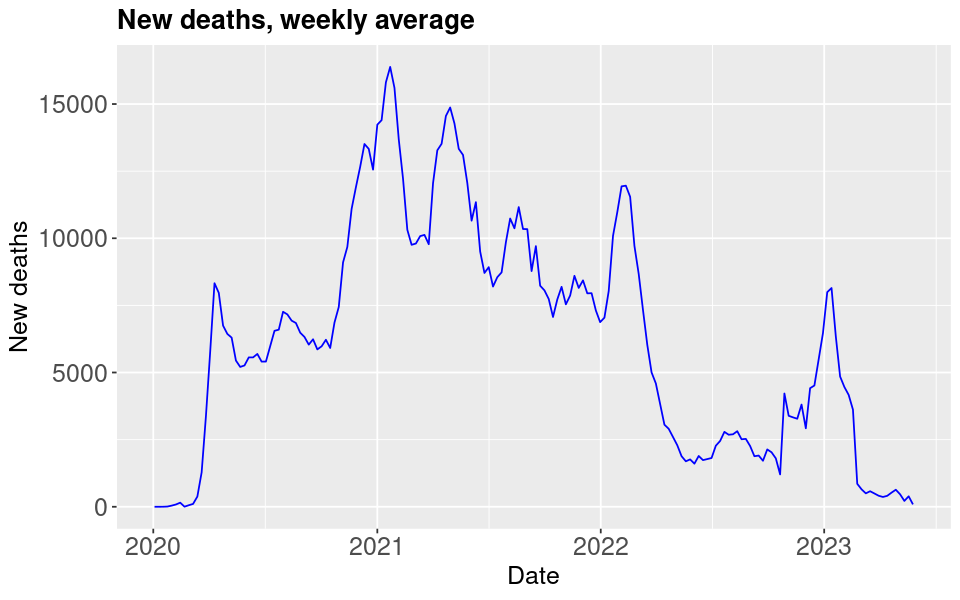

In [42]:
p <- ggplot() + geom_line(aes(x = days, y = deaths), color = "blue")
p + ggtitle("New deaths, weekly average") + labs(x = "Date", y = "New deaths") + theme